In [ ]:
from datasets import load_dataset
import spacy
from konlpy.tag import Okt
from collections import Counter
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
import os
from nltk.stem import WordNetLemmatizer
import stanza
from kiwipiepy import Kiwi 
from collections import defaultdict
import re

In [ ]:

def load_wikipedia_data(lang, sample_size=20000):
    wiki = load_dataset("wikimedia/wikipedia", f"20231101.{lang}", split="train", columns=["text"])
    return wiki.shuffle(seed=2025).select(range(sample_size)).to_pandas()

def clean_text_list(text_list):
    cleaned = []
    for item in text_list:
        # Split lines to handle \n cleanly
        # Remove extra spaces, tabs, etc.
        item = item.strip()                         # Strip leading/trailing space
        item = re.sub(r'\s+', ' ', item)            # Normalize all whitespace            line = re.sub(r'[^\S\r\n]+', ' ', line)     # Remove extra non-visible spaces
        if item:                                    # Remove empty strings
            cleaned.append(item)
    return cleaned


def extract_nouns_with_sentences_and_frequency(text, lang, lemmatizer=None, nlp=None, kiwi=None):
    """
    Extract nouns, their frequencies, and the sentences containing them from the given text.
    
    Args:
        text (str): The input text.
        lang (str): The language of the text ('en', 'de', 'ko').
        lemmatizer (WordNetLemmatizer, optional): Lemmatizer for English.
        nlp (stanza.Pipeline, optional): Stanza pipeline for German.
        kiwi (Kiwi, optional): Kiwi tokenizer for Korean.
    
    Returns:
        dict: A dictionary where keys are nouns and values are tuples of (frequency, list of sentences containing the noun).
    """
    noun_to_data = {}

    # Split the text into sentences
    # sentences = re.split(r'(?<=[.!?])\s+', text)

    if lang == "en":
        tokens = word_tokenize(text)
        tagged = pos_tag(tokens)
        nouns = [
            lemmatizer.lemmatize(word.lower()) 
            for word, tag in tagged 
            if tag in ['NN', 'NNS']
        ]
        sentences = sent_tokenize(text)
    elif lang == "de":
        doc = nlp(text)
        nouns = [
            word.lemma
            for sentence in doc.sentences
            for word in sentence.words
            if word.upos == "NOUN"
        ]
        sentences = [sentence.text for sentence in doc.sentences]
    elif lang == "ko":
        doc = kiwi.tokenize(text)
        nouns = [
            token.form
            for token in doc
            if token.tag == "NNG"
        ]
        sentences = kiwi.split_into_sents(text)
        sentences = [s.text for s in sentences]
    else:
        raise ValueError("Unsupported language")
    
    sentences = clean_text_list(sentences)

    # Count noun frequencies
    noun_frequencies = Counter(nouns)

    # Map nouns to sentences
    for sentence in sentences:
        for noun in noun_frequencies.keys():
            if re.search(rf'\b{re.escape(noun)}\b', sentence, re.IGNORECASE):
                if noun not in noun_to_data:
                    noun_to_data[noun] = {"frequency": noun_frequencies[noun], "sentences": []}
                noun_to_data[noun]["sentences"].append(sentence)

    return noun_to_data

In [ ]:
def process_wikipedia_nouns(lang):
    df = load_wikipedia_data(lang)
    
    if lang == "en":
        print("Extracting nouns using nltk for English...")
        lemmatizer = WordNetLemmatizer()
        tqdm.pandas(desc="Processing text")
        df["noun_frequencies"] = df["text"].progress_apply(lambda text: extract_nouns_with_sentences_and_frequency(text, lang, lemmatizer=lemmatizer))

    elif lang == "de":
        print(f"Extracting nouns using Stanza model for {lang}...")
        nlp = stanza.Pipeline(lang="de", processors="tokenize,pos,lemma", use_gpu=True)  # Initialize Stanza pipeline
        tqdm.pandas(desc="Processing text")
        df["noun_frequencies"] = df["text"].progress_apply(lambda text: extract_nouns_with_sentences_and_frequency(text, lang, nlp=nlp))

    elif lang == "ko":
        print(f"Extracting nouns using Kiwi tokenizer for {lang}...")
        kiwi = Kiwi()
        tqdm.pandas(desc="Processing text")
        df["noun_frequencies"] = df["text"].progress_apply(lambda text: extract_nouns_with_sentences_and_frequency(text, lang, kiwi=kiwi))

    final_data = defaultdict(lambda: {"frequency": 0, "sentences": []})

    # Iterate over the rows of df["noun_frequencies"]
    for noun_data in df["noun_frequencies"]:
        for noun, data in noun_data.items():
            # Add the frequency of the noun
            final_data[noun]["frequency"] += data["frequency"]
            # Extend the list of sentences containing the noun
            final_data[noun]["sentences"].extend(data["sentences"])

    # Convert the defaultdict to a regular dictionary
    final_data = {noun: {"frequency": data["frequency"], "sentences": list(set(data["sentences"]))} 
                for noun, data in final_data.items()}

    # Convert the final data into a DataFrame (optional)
    noun_frequencies_df = pd.DataFrame([
        {"noun": noun, "frequency": data["frequency"], "sentences": data["sentences"]}
        for noun, data in final_data.items()
    ])

    # Display the DataFrame
    noun_frequencies_df.sort_values(by="frequency", ascending=False, inplace=True)


    if lang == "en":
        noun_frequencies_df = noun_frequencies_df[~noun_frequencies_df['word'].str.contains(r'[^a-zA-Z]', na=False)]
    if lang == "de":
        noun_frequencies_df = noun_frequencies_df[~noun_frequencies_df['word'].str.contains(r'[^a-zA-ZäöüÄÖÜß]', na=False)]
    if lang == "ko":
        noun_frequencies_df = noun_frequencies_df[~noun_frequencies_df['word'].str.contains(r'[^\uac00-\ud7a3]', na=False)]

    noun_frequencies_df = noun_frequencies_df[noun_frequencies_df["frequency"] >= 4]
    noun_frequencies_df = noun_frequencies_df.drop_duplicates(subset="noun").reset_index(drop=True)

    selected_sentences = {}
    for word, texts, frequency in tqdm(noun_frequencies_df[["noun", "sentences", "frequency"]].values):
        # Filter sentences with word length between 10 and 20
        valid_sentences = [text for text in texts if 10 <= len(text.split()) <= 20]
        
        if valid_sentences:
            # If there are valid sentences, choose the first one
            selected_sentence = valid_sentences[0]
        else:
            # If no valid sentences, choose the one closest to the range
            selected_sentence = min(texts, key=lambda text: abs(len(text.split()) - 15))  # Closest to the midpoint (15)

        # Save the selected sentence, its word length, and the original frequency
        selected_sentences[word] = {
            "selected_sentence": selected_sentence,
            "sentence_length": len(selected_sentence.split()),
            "original_frequency": frequency
        }

    # Convert the selected sentences into a DataFrame
    selected_sentences_df = pd.DataFrame(
        [
            {
                "word": word,
                "selected_sentence": data["selected_sentence"],
                "sentence_length": data["sentence_length"],
                "original_frequency": data["original_frequency"]
            }
            for word, data in selected_sentences.items()
        ]
    )
    
    return selected_sentences_df

In [34]:
lemmatizer = WordNetLemmatizer()
tqdm.pandas(desc="Processing text")
df["noun_frequencies"] = df["text"].progress_apply(lambda text: extract_nouns_with_sentences_and_frequency(text, lang="en", lemmatizer=lemmatizer))

Processing text: 100%|██████████| 20000/20000 [16:40<00:00, 19.99it/s]  


In [ ]:
from collections import defaultdict

# Initialize a dictionary to store the aggregated data
final_data = defaultdict(lambda: {"frequency": 0, "sentences": []})

# Iterate over the rows of df["noun_frequencies"]
for noun_data in df["noun_frequencies"]:
    for noun, data in noun_data.items():
        # Add the frequency of the noun
        final_data[noun]["frequency"] += data["frequency"]
        # Extend the list of sentences containing the noun
        final_data[noun]["sentences"].extend(data["sentences"])

# Convert the defaultdict to a regular dictionary
final_data = {noun: {"frequency": data["frequency"], "sentences": list(set(data["sentences"]))} 
              for noun, data in final_data.items()}

# Convert the final data into a DataFrame (optional)
final_df = pd.DataFrame([
    {"noun": noun, "frequency": data["frequency"], "sentences": data["sentences"]}
    for noun, data in final_data.items()
])

# Display the DataFrame
final_df.sort_values(by="frequency", ascending=False, inplace=True)
final_df.head()


,noun,frequency,sentences
0,footballer,2867,"[People with the surname\n Alastair Aird, Brit..."
1,goalkeeper,202,"[Meanwhile, young Norwegian goalkeeper Mats Mø..."
2,career,4456,[MAASK) is a brigade-level unit of the Finnish...
3,substitute,186,"[On 11 December 2004, he received a red card f..."
4,loan,557,[Despite this he went on loan to Stord in the ...


In [49]:
final_df = final_df[~final_df['noun'].str.contains(r'[^a-zA-Z]', na=False)].drop_duplicates(subset="noun").reset_index(drop=True)

In [ ]:
final_df = final_df[final_df["frequency"] >= 4]
final_df

,noun,frequency,sentences
0,people,12815,[He found that while trying to solve the probl...
1,year,11940,[Discovery of Australia by de Queirós in the Y...
2,film,11356,[The episode stars Diego Luna as Cassian Andor...
3,time,10655,"[In a 2/5 review of the PC version, Hardcore G..."
4,season,8079,[After starting for Coventry in their 1–0 away...
...,...,...,...
15361,clamp,4,[This is in accordance with the large incisors...
15362,directeur,4,"[After retiring from cycling in 1972, he went ..."
15363,maronites,4,[Catholic political parties\nChristian politic...
15364,ethnomusicologists,4,"[(Glitterbeat Records, June 2023) - Taa langua..."


In [52]:
selected_sentences = {}
for word, texts in tqdm(final_df[["noun","sentences"]].values):

    # Filter sentences with word length between 10 and 20
    valid_sentences = [text for text in texts if 10 <= len(text.split()) <= 20]
    
    if valid_sentences:
        # If there are valid sentences, choose the first one
        selected_sentence = valid_sentences[0]
    else:
        # If no valid sentences, choose the one closest to the range
        selected_sentence = min(texts, key=lambda text: abs(len(text.split()) - 15))  # Closest to the midpoint (15)

    # Save the selected sentence and its word length
    selected_sentences[word] = {
        "selected_sentence": selected_sentence,
        "sentence_length": len(selected_sentence.split())
    }

# # Convert the selected sentences into a DataFrame
# selected_sentences_df = pd.DataFrame(
#     [{"word": word, "selected_sentence": data["selected_sentence"], "sentence_length": data["sentence_length"]}
#      for word, data in selected_sentences.items()]
# )


100%|██████████| 49490/49490 [00:02<00:00, 17800.89it/s]


In [53]:
selected_sentences

{'people': {'selected_sentence': 'Israeli guitarists\nJewish Israeli musicians\nMusicians from Jerusalem\n1954 births\nLiving people\nIsraeli male poets',
  'sentence_length': 15},
 'year': {'selected_sentence': 'Discovery of Australia by de Queirós in the Year 1606 by Patrick F.',
  'sentence_length': 13},
 'film': {'selected_sentence': 'Plot\n\nMuch like the film and novel which it is based on, Dr.',
  'sentence_length': 13},
 'time': {'selected_sentence': 'In a 2/5 review of the PC version, Hardcore Gamer wrote, "Toast Time is fun, but shallow.',
  'sentence_length': 17},
 'season': {'selected_sentence': 'The regular season began on September 20, 2019, and was scheduled to end on March 22, 2020.',
  'sentence_length': 17},
 'player': {'selected_sentence': 'He was a keen Chess player and played for Rathmines Chess Club in the Leinster Leagues.',
  'sentence_length': 16},
 'team': {'selected_sentence': "In October 2017, the  team announced Earle's signing, securing him on a two-year d

In [26]:
LANGUAGE = "English"
LANGUAGE_MAP = {
    "English": "en",
    "German": "de",
    "Korean": "ko"}
# MODEL_NAME = "Babel-9B-Chat"
MODEL_NAME = "gemma-3-12b-it"

In [27]:
from datasets import load_dataset
import pandas as pd
from collections import defaultdict
import re
from tqdm import tqdm

def load_wikipedia_data(lang, sample_size=20000):
    wiki = load_dataset("wikimedia/wikipedia", f"20231101.{lang}", split="train", columns=["text"])
    return wiki.shuffle(seed=2025).select(range(sample_size)).to_pandas()

df = load_wikipedia_data(lang=LANGUAGE_MAP[LANGUAGE])

path = f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/WordNonword/r1_dataset_{MODEL_NAME}_{LANGUAGE}-wiki-2token.csv"
word_list = pd.read_csv(path)["word"].tolist()

# Preprocess the text column to tokenize and normalize words
df['processed_text'] = df['text'].str.lower().str.findall(r'\b\w+\b')

# Create an inverted index: a mapping from each word to the rows it appears in
inverted_index = defaultdict(list)
for idx, words in enumerate(df['processed_text']):
    for word in set(words):  # Use set to avoid duplicate entries for the same word in a row
        inverted_index[word].append(idx)

# Build the word_to_texts dictionary using the inverted index
word_to_texts = {}
for word in tqdm(word_list):
    normalized_word = word.lower()  # Normalize the word
    matching_indices = inverted_index.get(normalized_word, [])  # Get matching row indices
    matching_texts = df.loc[matching_indices, 'text'].tolist()  # Retrieve matching texts

    # Extract sentences containing the word
    sentences_with_word = []
    for text in matching_texts:
        sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences
        for sentence in sentences:
            if re.search(rf'\b{normalized_word}\b', sentence, re.IGNORECASE):  # Check if the word is in the sentence
                sentences_with_word.append(sentence)

    word_to_texts[word] = sentences_with_word  # Save only the sentences containing the word
    
    
# # Create a DataFrame from word_to_texts
# data = []
# for word, texts in word_to_texts.items():
#     num_texts = len(texts)  # Length of the value list
#     avg_word_len = sum(len(text.split()) for text in texts) / num_texts if num_texts > 0 else 0  # Average word length
#     min_word_len = min(len(text.split()) for text in texts) if texts else 0  # Minimum word length
#     data.append({"word": word, "num_texts": num_texts, "avg_word_len": avg_word_len, "min_word_len": min_word_len, "texts": texts})

# # Convert the list of dictionaries into a DataFrame
# word_to_texts_df = pd.DataFrame(data)

# # Display the DataFrame
# word_to_texts_df.head()

import pandas as pd
from tqdm import tqdm

# Create a dictionary to store the selected sentence and its word length for each word
selected_sentences = {}

for word, texts in tqdm(word_to_texts.items()):
    if not texts:
        # If the texts list is empty, assign None or a placeholder
        selected_sentences[word] = {"selected_sentence": None, "sentence_length": 0}
        continue

    # Filter sentences with word length between 10 and 20
    valid_sentences = [text for text in texts if 10 <= len(text.split()) <= 20]
    
    if valid_sentences:
        # If there are valid sentences, choose the first one
        selected_sentence = valid_sentences[0]
    else:
        # If no valid sentences, choose the one closest to the range
        selected_sentence = min(texts, key=lambda text: abs(len(text.split()) - 15))  # Closest to the midpoint (15)

    # Save the selected sentence and its word length
    selected_sentences[word] = {
        "selected_sentence": selected_sentence,
        "sentence_length": len(selected_sentence.split())
    }

# Convert the selected sentences into a DataFrame
selected_sentences_df = pd.DataFrame(
    [{"word": word, "selected_sentence": data["selected_sentence"], "sentence_length": data["sentence_length"]}
     for word, data in selected_sentences.items()]
)

# Display the DataFrame
selected_sentences_df.head()


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [00:00<00:00, 17145.77it/s]


,word,selected_sentence,sentence_length
0,mecenas,The title of mecenas is purely a matter of cou...,17
1,urinal,25th Anniversary Exhibition of the Arts Studen...,421
2,asiddha,"But, since two entities can be replaced by eac...",20
3,linden,"Verlag von der Linden, Wesel 2009\n In Search ...",11
4,smoky,She created the modern smoky eye makeup look i...,17


,word,selected_sentence,sentence_length
0,mecenas,The title of mecenas is purely a matter of cou...,17
2,asiddha,"But, since two entities can be replaced by eac...",20
3,linden,"Verlag von der Linden, Wesel 2009\n In Search ...",11
4,smoky,She created the modern smoky eye makeup look i...,17
5,pecan,"The menu includes alambres, chilaquiles, enchi...",19
...,...,...,...
5771,sive,Works\nLogicae seu philosophiae rationalis ele...,12
5882,pty,15 November 2015 the channel owner Garage Ente...,17
5926,purulent,"Cloudy, purulent, turbid: Infection, empyema, ...",7
5945,blass,Andreas Blass was the first to point out conne...,15


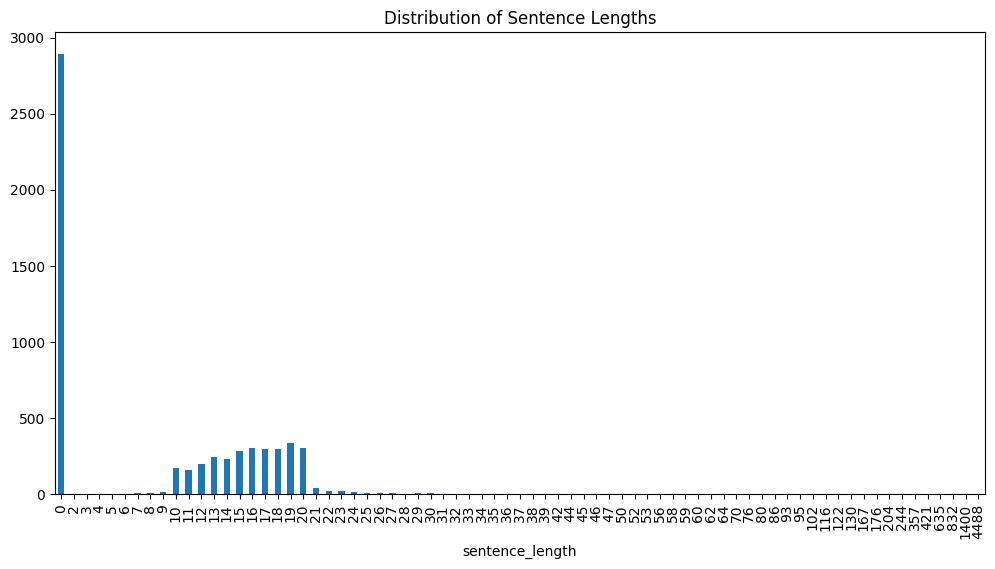

In [29]:
selected_sentences_df["sentence_length"].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Distribution of Sentence Lengths')
selected_sentences_df[(selected_sentences_df["sentence_length"] > 5) & (selected_sentences_df["sentence_length"] < 25)]

In [9]:
import pandas as pd

# Create a DataFrame from word_to_texts
data = []
for word, texts in word_to_texts.items():
    num_texts = len(texts)  # Length of the value list
    avg_word_len = sum(len(text.split()) for text in texts) / num_texts if num_texts > 0 else 0  # Average word length
    min_word_len = min(len(text.split()) for text in texts) if texts else 0  # Minimum word length
    data.append({"word": word, "num_texts": num_texts, "avg_word_len": avg_word_len, "min_word_len": min_word_len, "texts": texts})

# Convert the list of dictionaries into a DataFrame
word_to_texts_df = pd.DataFrame(data)

# Display the DataFrame
word_to_texts_df.head()

,word,num_texts,avg_word_len,min_word_len,texts
0,aphid,2,17.000000,15,"[Phyllaphis fagi, the woolly beech aphid, is a..."
1,frail,8,36.000000,21,[In a variant collected by from Harbachtal wi...
2,excludes,24,48.458333,9,[The data excludes viewing that occurred on Ne...
3,upconversion,5,20.600000,12,"[Photon upconversion\n\nAs discussed above, ph..."
4,beige,11,18.272727,5,[The modernist glass towers were covered in br...


In [16]:
import pandas as pd
from tqdm import tqdm

# Create a dictionary to store the selected sentence and its word length for each word
selected_sentences = {}

for word, texts in tqdm(word_to_texts.items()):
    if not texts:
        # If the texts list is empty, assign None or a placeholder
        selected_sentences[word] = {"selected_sentence": None, "sentence_length": 0}
        continue

    # Filter sentences with word length between 10 and 20
    valid_sentences = [text for text in texts if 10 <= len(text.split()) <= 20]
    
    if valid_sentences:
        # If there are valid sentences, choose the first one
        selected_sentence = valid_sentences[0]
    else:
        # If no valid sentences, choose the one closest to the range
        selected_sentence = min(texts, key=lambda text: abs(len(text.split()) - 15))  # Closest to the midpoint (15)

    # Save the selected sentence and its word length
    selected_sentences[word] = {
        "selected_sentence": selected_sentence,
        "sentence_length": len(selected_sentence.split())
    }

# Convert the selected sentences into a DataFrame
selected_sentences_df = pd.DataFrame(
    [{"word": word, "selected_sentence": data["selected_sentence"], "sentence_length": data["sentence_length"]}
     for word, data in selected_sentences.items()]
)

# Display the DataFrame
selected_sentences_df.head()

100%|██████████| 5999/5999 [00:00<00:00, 12662.52it/s]


,word,selected_sentence,sentence_length
0,aphid,"Phyllaphis fagi, the woolly beech aphid, is a ...",15
1,frail,"The tornado was officially given an F5 rating,...",21
2,excludes,The data excludes viewing that occurred on Net...,13
3,upconversion,"Photon upconversion\n\nAs discussed above, pho...",18
4,beige,The modernist glass towers were covered in bri...,13


<Axes: title={'center': 'Distribution of Sentence Lengths'}, xlabel='sentence_length'>

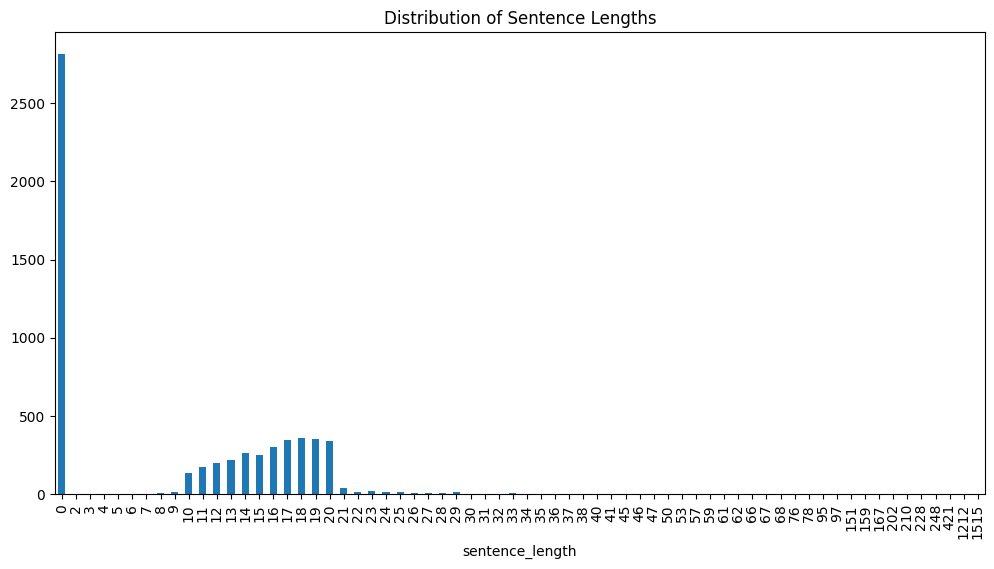

In [18]:
selected_sentences_df["sentence_length"].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Distribution of Sentence Lengths')

In [21]:
selected_sentences_df[(selected_sentences_df["sentence_length"] > 5) & (selected_sentences_df["sentence_length"] < 25)]

,word,selected_sentence,sentence_length
0,aphid,"Phyllaphis fagi, the woolly beech aphid, is a ...",15
1,frail,"The tornado was officially given an F5 rating,...",21
2,excludes,The data excludes viewing that occurred on Net...,13
3,upconversion,"Photon upconversion\n\nAs discussed above, pho...",18
4,beige,The modernist glass towers were covered in bri...,13
...,...,...,...
5948,reposition,"Instead, the Governor serves at the pleasure o...",21
5951,eo,The dates also suggest that Óc Eo was also inh...,16
5953,amide,KetoDrug:A web server for binding affinity pre...,16
5975,sers,Bin Chen's journal articles include Molecular ...,23


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append("/home/hyujang/multilingual-inner-lexicon/RQ1/WordIdentity")
from logitlens import LogitLens

In [2]:
# MODEL_NAME = "Tower-Babel/Babel-9B-Chat"
MODEL_NAME = "google/gemma-3-27b-it"
LANGUAGE = "English"
logit_lens = LogitLens(LANGUAGE, MODEL_NAME, output_type="ffn_hidden_states", retreival_type="cumulative")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/972 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

model-00003-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00006-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00008-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00007-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00012.safetensors:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

model-00004-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00005-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00009-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00010-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00011-of-00012.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00012-of-00012.safetensors:   0%|          | 0.00/462M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Model google/gemma-3-27b-it for English loaded successfully.


In [8]:
import torch
language = logit_lens.language
logit_lens.model.eval()  # Set the model to evaluation mode
for word in word_list[:10]:
    print(word)
    # prompt = f"Write a single, well-formed sentence between 10 and 20 words long that uses the word '{word}' in a clear and meaningful context."
    # prompt = f"Write exactly one complete sentence that is 10 to 20 words long and includes the word '{word}'. Only output the sentence—no explanations or extra text. Do not use the word '{word}' as a verb or adjective; it should be used as a noun."
    # prompt = f"Generate a sentence that includes the word '{word}' in a meaningful context with length 10-20 words. Only output the sentence without any additional text. The word '{word}' should be used as a noun."
    prompt = f"""Generate excatly one single, self-contained {language} sentence (10–20 words) that includes the word "{word}" (without changing form) in a meaningful context. 
Respond ONLY with a JSON object in the following format:

{{"sentence": "<your sentence here>"}}
"""
    # Tokenize input
    inputs = logit_lens.tokenizer(prompt, return_tensors="pt").to(logit_lens.model.device)

    # Generate output
    with torch.no_grad():
        output_ids = logit_lens.model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=True,      # deterministic
            top_p=0.9,
            temperature=0.3,
            eos_token_id=logit_lens.tokenizer.eos_token_id
        )

    # Decode output
    output_text = logit_lens.tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    if output_text.startswith(prompt):
        generated_sentence = output_text[len(prompt):].strip()
    else:
        generated_sentence = output_text.strip()

    print("Generated:", generated_sentence)


aphid
Generated: ```json
{"sentence": "The gardener carefully removed the aphid infestation from the rose bushes with a strong spray of water."}
```
frail
Generated: ```json
{"sentence": "The elderly woman, looking frail and tired, slowly walked with the aid of a cane."}
```
excludes
Generated: ```json
{"sentence": "The new policy excludes pre-existing conditions, which unfortunately limits coverage for many applicants."}
```
upconversion
Generated: ```json
{"sentence": "Researchers are exploring upconversion nanoparticles for enhanced bioimaging and photodynamic therapy applications."}
```
beige
Generated: ```json
{"sentence": "The living room's decor featured a calming palette of cream, gray, and soft beige tones."}
```
pellet
Generated: ```json
{"sentence": "The rabbit eagerly munched on the alfalfa pellet, a nutritious part of its daily diet."}
```
addressing


KeyboardInterrupt: 

In [17]:
output_ids

tensor([[31115,   264, 11652,   429,  5646,   279,  3409,   364,  1342,   307,
             6,   304,   264, 22414,  2266,   448,  3084,   220,    16,    15,
            12,    17,    15,  4244,    13,  8278,  2550,   279, 11652,  2041,
           894,  5107,  1467,    13,   576,  3409,   364,  1342,   307,     6,
          1265,   387,  1483,   438,   264, 36921,    13,   576, 11652,  1265,
           537,  6644,   894, 15183,  4128,   476, 32681,  2213,    13,   576,
         11652,  1265,   387, 68125,  7022,  4396,   323]], device='cuda:0')